In [1]:
from jsonschema.exceptions import best_match
from torchvision.datasets import MNIST, CIFAR10
from win32comext.adsi.demos.scp import verbose

from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets, cifar10_augment, basic_cifar10_augment
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.layer.blocks import BasicBlock
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp
from mynn.attack import pgd_kl_attack

In [2]:
test_dataset = CIFAR10(
    root="../cifar10",
    train=False,
    transform=basic_cifar10_augment(train=False),
    download=False
)
test_images, test_labels = preprocess(test_dataset)
test_images = cp.asarray(test_images)
test_labels = cp.asarray(test_labels)

test_set = (test_images, test_labels)
import numpy as np

print("Min pixel value:", cp.min(test_images))
print("Max pixel value:", cp.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


# basic model

In [7]:
model = Model().load_model('best_model_basic/VGG-base-train/best_model.pickle')

Model loaded from: best_model_basic\VGG-base-train\best_model.pickle


In [8]:
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)
# 5. 评估并输出
test_loss, test_acc = runner.evaluate(test_set, batch_size=128, loss_fn=loss_fn)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.9749, Test accuracy: 0.7832


攻击系数： epsilon=8/255，num_steps=10,step_size=10

In [14]:
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=8/255,
    num_steps=10,
    step_size=1/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Processing batches: 100%|███████████████████████████████████████████| 79/79 [11:04<00:00,  8.42s/it]


In [16]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 15.20273, Test accuracy: 0.00219


Displaying original images...


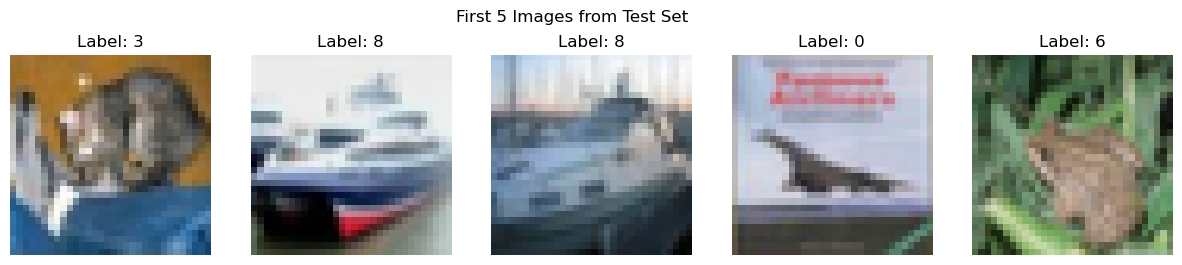

Displaying adversarial images...


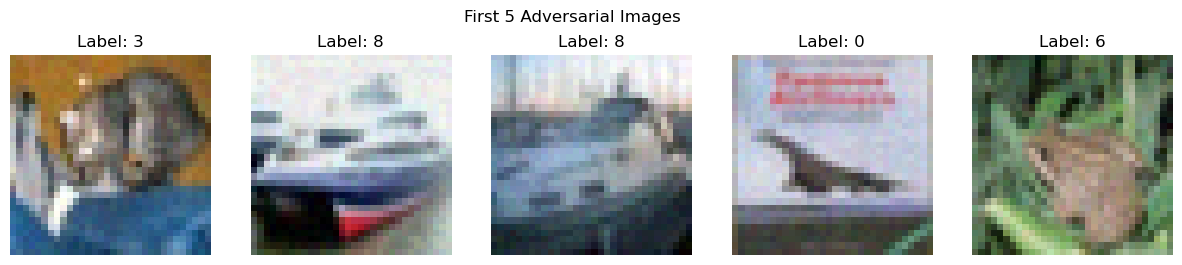

In [15]:
import matplotlib.pyplot as plt


def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()


print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images") 

系数： epsilon=2/255, num_steps=10, step_size=0.5/255,

In [17]:
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=10,
    step_size=0.5/255,
    batch_size=128,
)

test_set_adv = (adv_test_images, test_labels)

Processing batches: 100%|███████████████████████████████████████████| 79/79 [11:04<00:00,  8.41s/it]


In [18]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 6.69196, Test accuracy: 0.19327


Displaying original images...


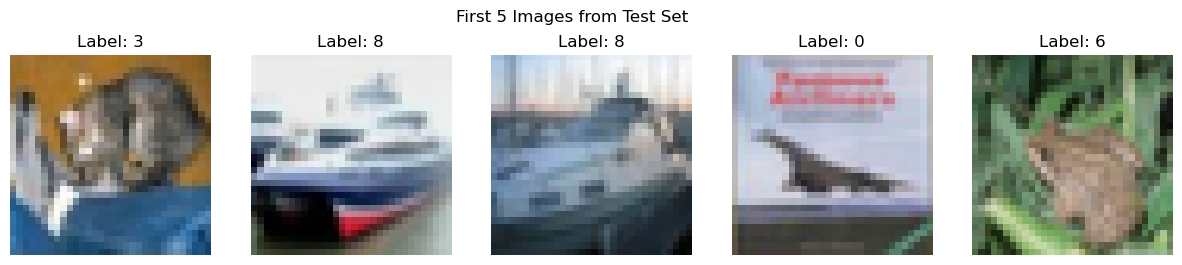

Displaying adversarial images...


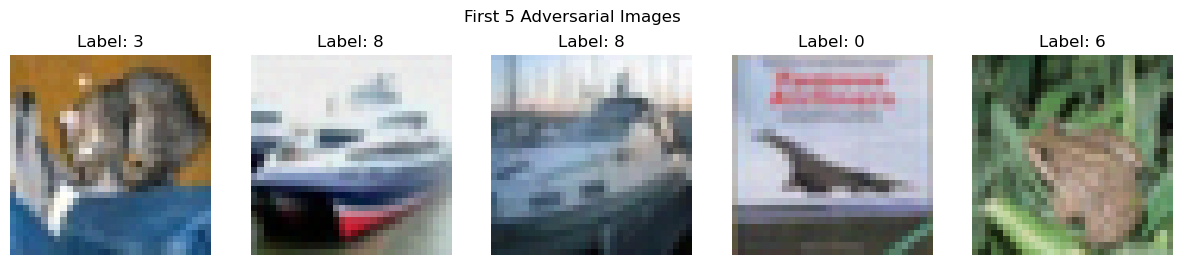

In [19]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

参数： epsilon=2/255,num_steps=20,step_size=0.5/255,

In [20]:
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=20,
    step_size=0.5/255,
    batch_size=128,
)

test_set_adv = (adv_test_images, test_labels)

Processing batches: 100%|███████████████████████████████████████████| 79/79 [22:50<00:00, 17.35s/it]


In [22]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 6.89579, Test accuracy: 0.17904


Displaying original images...


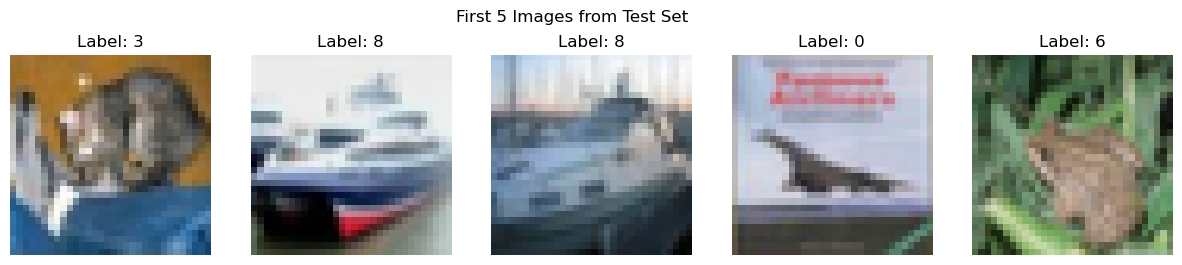

Displaying adversarial images...


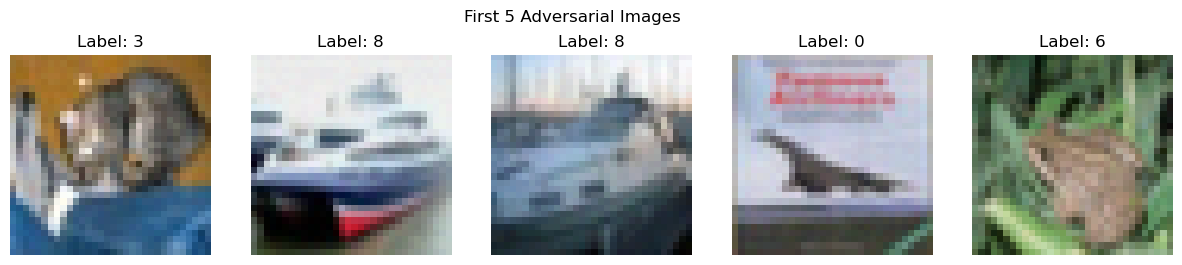

In [21]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

In [23]:
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=5,
    step_size=0.5/255,
    batch_size=128,
)

test_set_adv = (adv_test_images, test_labels)

Processing batches: 100%|███████████████████████████████████████████| 79/79 [05:32<00:00,  4.20s/it]


In [24]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 5.73901, Test accuracy: 0.23925


In [ ]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

one step

In [27]:
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=1,
    step_size=1/255,
    batch_size=128,
)

test_set_adv = (adv_test_images, test_labels)

Processing batches: 100%|███████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]


In [28]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.53477, Test accuracy: 0.61296


# adv model 


In [3]:
model = Model().load_model('best_model_trades/beta2/best_model.pickle')


Model loaded from: best_model_trades\beta2\best_model.pickle


In [4]:
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)
# 5. 评估并输出
test_loss, test_acc = runner.evaluate(test_set, batch_size=128, loss_fn=loss_fn)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.7763, Test accuracy: 0.7698


In [6]:
from mynn.attack import pgd_kl_attack
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=5,
    step_size=0.5/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Generating Adversarial Examples: 100%|██████████████████████████████| 79/79 [05:24<00:00,  4.11s/it]


In [7]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.76084, Test accuracy: 0.75358


num_step=10

In [8]:
from mynn.attack import pgd_kl_attack
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=2/255,
    num_steps=10,
    step_size=0.5/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Generating Adversarial Examples: 100%|██████████████████████████████| 79/79 [10:48<00:00,  8.21s/it]


In [9]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 0.74599, Test accuracy: 0.75247


bigger attack

In [5]:
from mynn.attack import pgd_kl_attack
adv_test_images = pgd_kl_attack(
    model=model, 
    images=test_images, 
    epsilon=4/255,
    num_steps=5,
    step_size=1/255,
    batch_size=128,
    verbose=True,
)

test_set_adv = (adv_test_images, test_labels)

Generating Adversarial Examples: 100%|██████████████████████████████| 79/79 [07:16<00:00,  5.52s/it]


In [6]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.11050, Test accuracy: 0.64646


other attack

In [7]:
from mynn.attack import  fgsm_attack
adv_test_images = fgsm_attack(
    model=model,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn,
    epsilon=1/255
)

test_set_adv = (adv_test_images, test_labels)

In [8]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128, loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.24589, Test accuracy: 0.66446
